In [ ]:
!nvidia-smi


Sun Nov 23 11:51:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             33W /   70W |    2620MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build

drive_service = build('drive', 'v3')
print("Authenticated successfully.")


Authenticated successfully.


In [ ]:
from google.colab import drive
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation")


Skipping, found downloaded files in "./lgg-mri-segmentation" (use force=True to force download)


In [ ]:
!ls lgg-mri-segmentation
!ls lgg-mri-segmentation/kaggle_3m


kaggle_3m  lgg-mri-segmentation
data.csv	       TCGA_DU_7018_19911220  TCGA_FG_A4MU_20030903
README.md	       TCGA_DU_7019_19940908  TCGA_FG_A60K_20040224
TCGA_CS_4941_19960909  TCGA_DU_7294_19890104  TCGA_HT_7473_19970826
TCGA_CS_4942_19970222  TCGA_DU_7298_19910324  TCGA_HT_7475_19970918
TCGA_CS_4943_20000902  TCGA_DU_7299_19910417  TCGA_HT_7602_19951103
TCGA_CS_4944_20010208  TCGA_DU_7300_19910814  TCGA_HT_7605_19950916
TCGA_CS_5393_19990606  TCGA_DU_7301_19911112  TCGA_HT_7608_19940304
TCGA_CS_5395_19981004  TCGA_DU_7302_19911203  TCGA_HT_7616_19940813
TCGA_CS_5396_20010302  TCGA_DU_7304_19930325  TCGA_HT_7680_19970202
TCGA_CS_5397_20010315  TCGA_DU_7306_19930512  TCGA_HT_7684_19950816
TCGA_CS_6186_20000601  TCGA_DU_7309_19960831  TCGA_HT_7686_19950629
TCGA_CS_6188_20010812  TCGA_DU_8162_19961029  TCGA_HT_7690_19960312
TCGA_CS_6290_20000917  TCGA_DU_8163_19961119  TCGA_HT_7692_19960724
TCGA_CS_6665_20010817  TCGA_DU_8164_19970111  TCGA_HT_7693_19950520
TCGA_CS_6666_20011109  TCGA_D

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

DATASET_PATH = "/content/lgg-mri-segmentation/kaggle_3m"

images = []
masks = []

print("⏳ Loading dataset...")

for folder in tqdm(os.listdir(DATASET_PATH)):
    folder_path = os.path.join(DATASET_PATH, folder)

    if not os.path.isdir(folder_path):
        continue

    files = os.listdir(folder_path)
    mask_files = [f for f in files if f.endswith("_mask.tif")]

    for mask_file in mask_files:
        mask_path = os.path.join(folder_path, mask_file)

        img_file = mask_file.replace("_mask", "")
        img_path = os.path.join(folder_path, img_file)

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        img = img / 255.0
        mask = (mask > 0).astype(np.float32)

        images.append(img)      # <-- keep as 128x128
        masks.append(mask)      # <-- keep as 128x128

images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

print("DONE!")
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


⏳ Loading dataset...


100%|██████████| 112/112 [00:06<00:00, 17.57it/s]


DONE!
Images shape: (3929, 128, 128)
Masks shape: (3929, 128, 128)


In [ ]:
# FILTER OUT images where mask has no tumor

filtered_images = []
filtered_masks = []

for img, mask in zip(images, masks):
    if mask.sum() > 0:  # keep only tumor masks
        filtered_images.append(img)
        filtered_masks.append(mask)

filtered_images = np.array(filtered_images, dtype=np.float32)
filtered_masks = np.array(filtered_masks, dtype=np.float32)

print("After filtering:")
print("Images:", filtered_images.shape)
print("Masks:", filtered_masks.shape)



After filtering:
Images: (1373, 128, 128)
Masks: (1373, 128, 128)


In [ ]:

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import numpy as np

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
])

class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images      # numpy (N,128,128)
        self.masks = masks        # numpy (N,128,128)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        img = self.images[idx]      # shape (128,128)
        mask = self.masks[idx]      # shape (128,128)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug["image"]
            mask = aug["mask"]

        # Add channel: (1,128,128)
        img = img[np.newaxis, :, :]
        mask = mask[np.newaxis, :, :]

        # Convert to torch
        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask



In [ ]:
from torch.utils.data import DataLoader

# Use filtered numpy arrays (DO NOT convert to tensor here)
train_dataset = BrainTumorDataset(
    filtered_images,
    filtered_masks,
    transform=transform        # augmentation only for training
)

# Test set (no augmentation)
test_dataset = BrainTumorDataset(
    filtered_images,
    filtered_masks,
    transform=None
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train loader and test loader are ready!")
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
img, m = train_dataset[0]
print(img.shape, m.shape)



Train loader and test loader are ready!
Train samples: 1373
Test samples: 1373
torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = DoubleConv(1, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool(d1)

        d2 = self.down2(p1)
        p2 = self.pool(d2)

        d3 = self.down3(p2)
        p3 = self.pool(d3)

        d4 = self.down4(p3)
        p4 = self.pool(d4)

        bn = self.bottleneck(p4)

        u1 = self.up1(bn)
        u1 = torch.cat([u1, d4], dim=1)
        u1 = self.conv1(u1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d3], dim=1)
        u2 = self.conv2(u2)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d2], dim=1)
        u3 = self.conv3(u3)

        u4 = self.up4(u3)
        u4 = torch.cat([u4, d1], dim=1)
        u4 = self.conv4(u4)

        return torch.sigmoid(self.output(u4))


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)

sample = torch.randn(1, 1, 128, 128).to(device)
output = model(sample)

print("Output shape:", output.shape)


Output shape: torch.Size([1, 1, 128, 128])


In [ ]:
import torch
import torch.nn as nn

# BCELoss (correct since model uses sigmoid)
bce_loss = nn.BCELoss()

def dice_loss(pred, target, smooth=1e-7):
    intersection = (pred * target).sum()
    return 1 - ((2 * intersection + smooth) /
                (pred.sum() + target.sum() + smooth))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 40
train_losses = []

model.train()

for epoch in range(num_epochs):
    epoch_loss = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)

        # loss = BCE + Dice
        loss = bce_loss(preds, masks) + dice_loss(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(train_loader):.4f}")

print("Training Completed!")



Epoch 1/40 - Loss: 1.2119
Epoch 2/40 - Loss: 0.8440
Epoch 3/40 - Loss: 0.7812
Epoch 4/40 - Loss: 0.7402
Epoch 5/40 - Loss: 0.7371
Epoch 6/40 - Loss: 0.6761
Epoch 7/40 - Loss: 0.6565
Epoch 8/40 - Loss: 0.6189
Epoch 9/40 - Loss: 0.5979
Epoch 10/40 - Loss: 0.5905
Epoch 11/40 - Loss: 0.5514
Epoch 12/40 - Loss: 0.5320
Epoch 13/40 - Loss: 0.5181
Epoch 14/40 - Loss: 0.4888
Epoch 15/40 - Loss: 0.4837
Epoch 16/40 - Loss: 0.4633
Epoch 17/40 - Loss: 0.4638
Epoch 18/40 - Loss: 0.4492
Epoch 19/40 - Loss: 0.4384
Epoch 20/40 - Loss: 0.4127
Epoch 21/40 - Loss: 0.4256
Epoch 22/40 - Loss: 0.3949
Epoch 23/40 - Loss: 0.3899
Epoch 24/40 - Loss: 0.3685
Epoch 25/40 - Loss: 0.3637
Epoch 26/40 - Loss: 0.3377
Epoch 27/40 - Loss: 0.3454
Epoch 28/40 - Loss: 0.3145
Epoch 29/40 - Loss: 0.3262
Epoch 30/40 - Loss: 0.3020
Epoch 31/40 - Loss: 0.3013
Epoch 32/40 - Loss: 0.2925
Epoch 33/40 - Loss: 0.2911
Epoch 34/40 - Loss: 0.2623
Epoch 35/40 - Loss: 0.2704
Epoch 36/40 - Loss: 0.2528
Epoch 37/40 - Loss: 0.2683
Epoch 38/4

In [ ]:

model_path = "/content/brain_tumor_unet_model.pth"
torch.save(model.state_dict(), model_path)
print("Saved:", model_path)



Saved: /content/brain_tumor_unet_model.pth


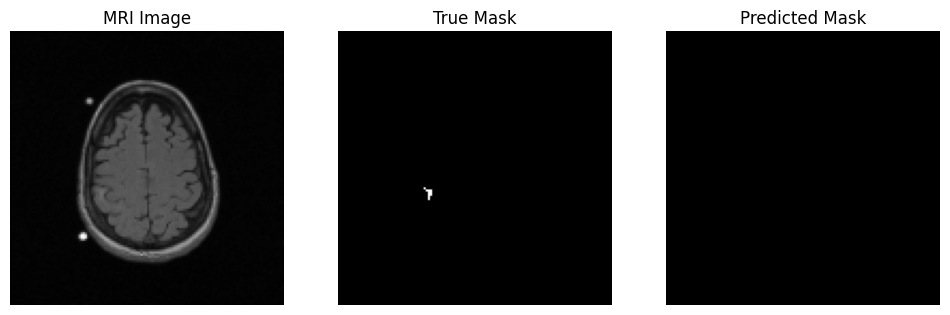

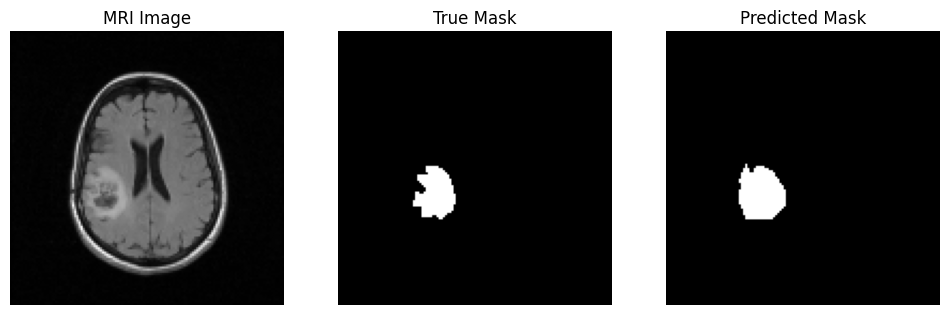

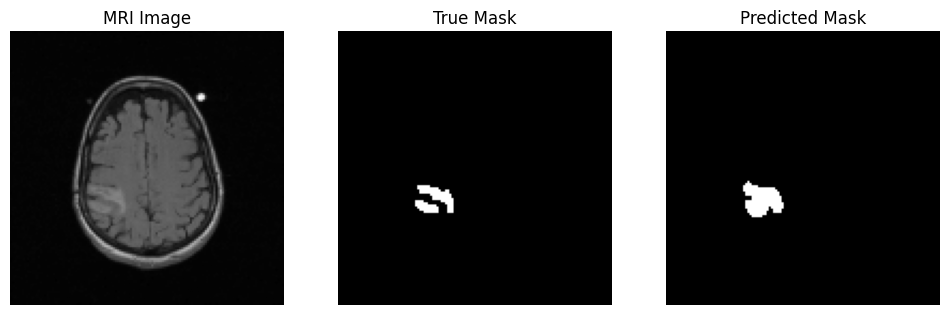

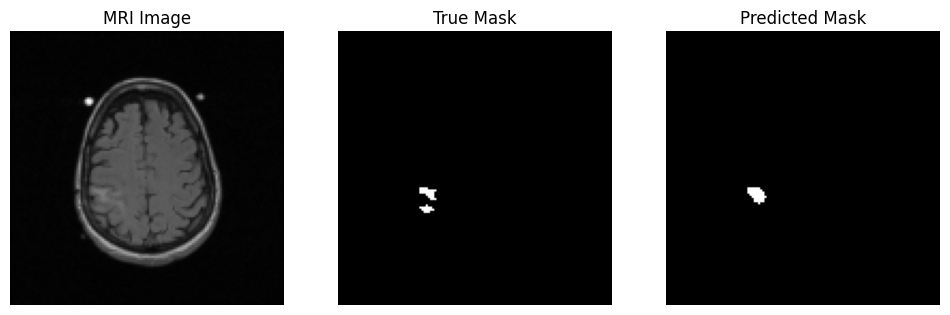

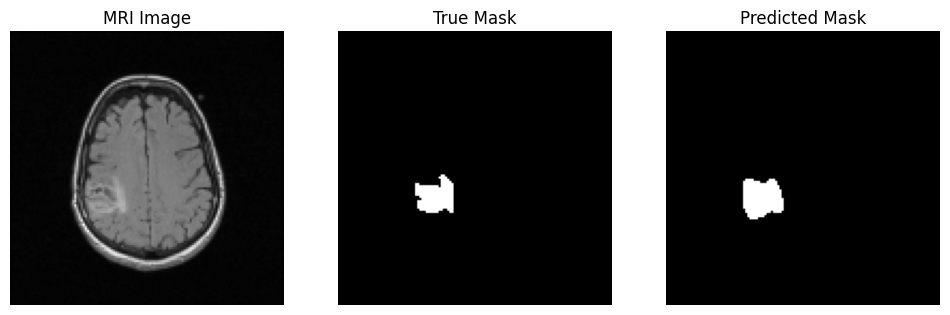

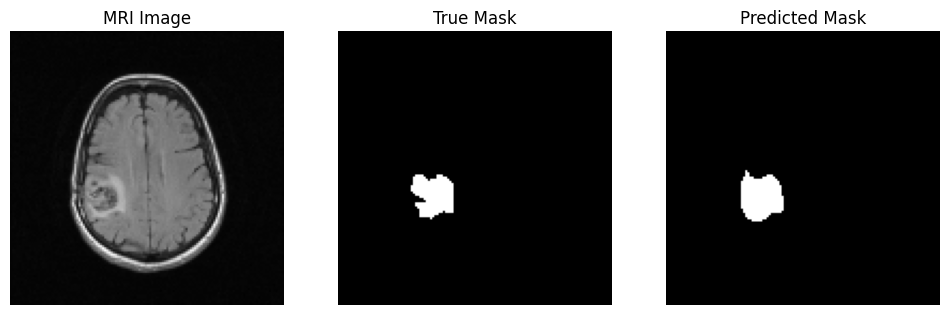

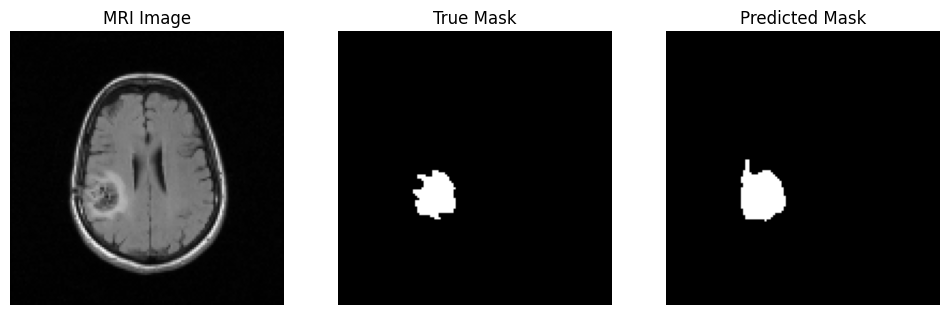

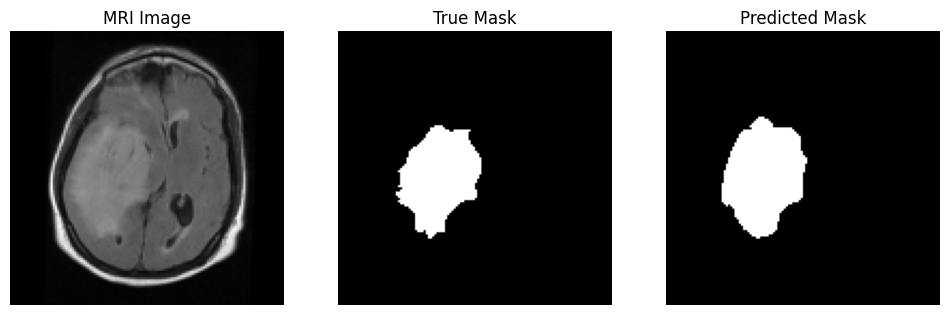

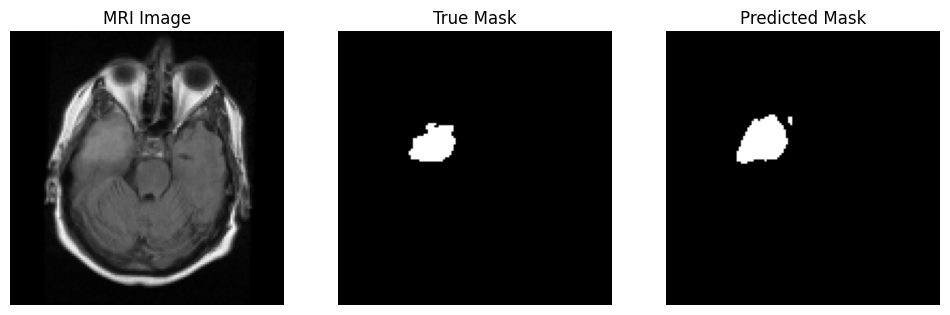

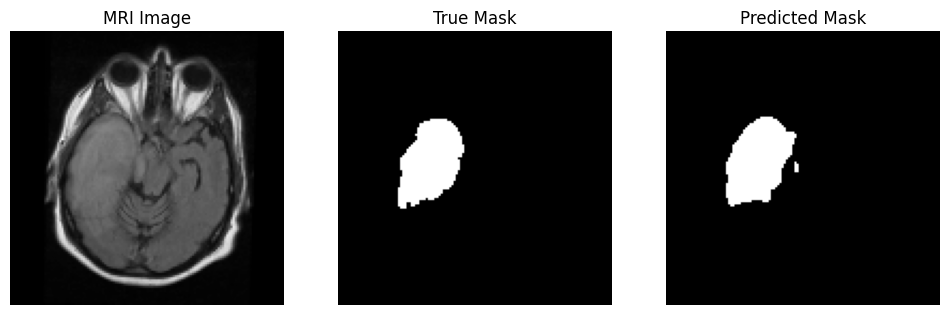

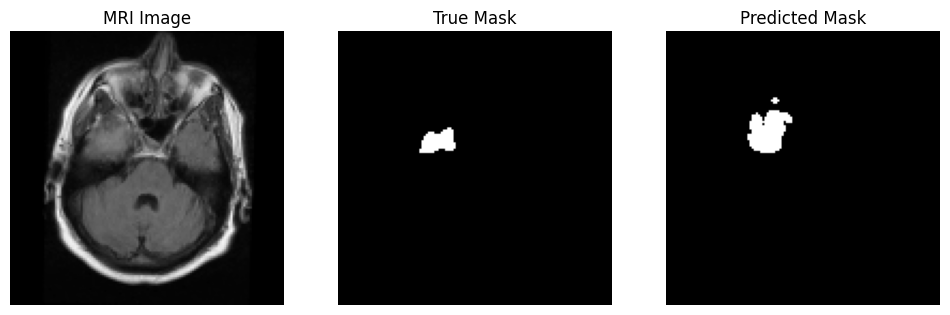

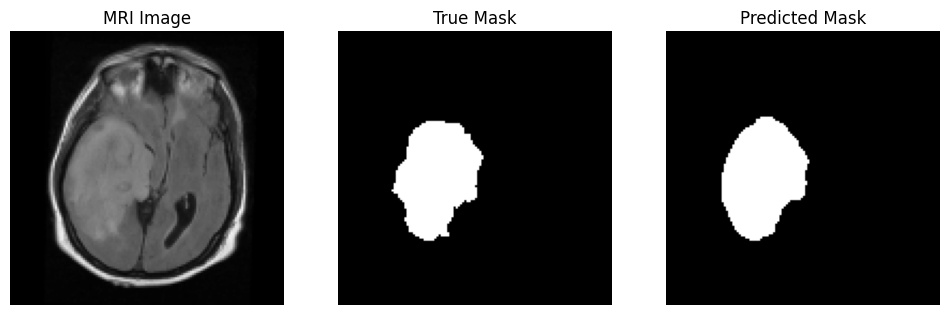

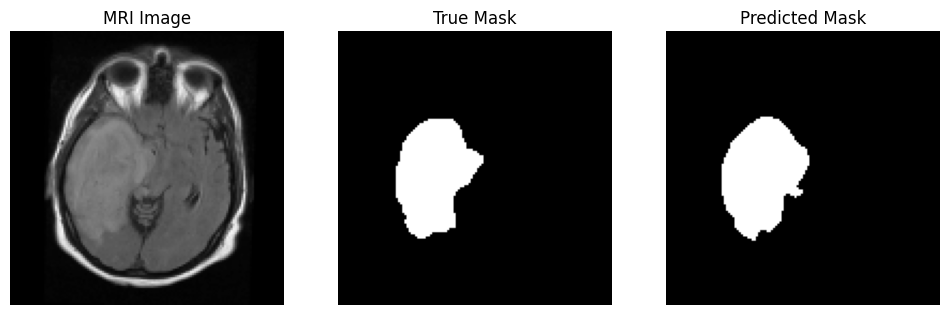

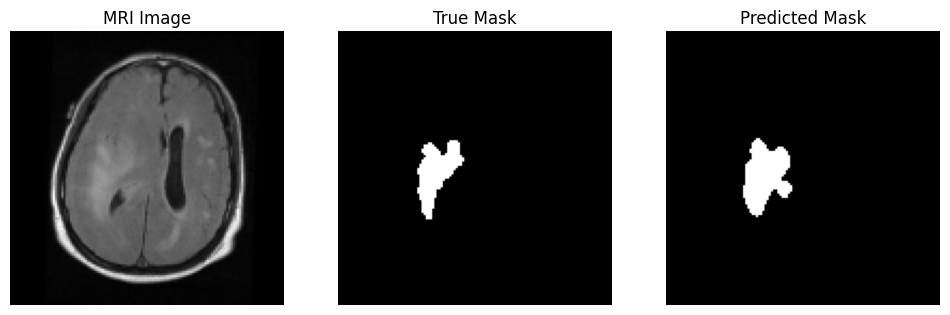

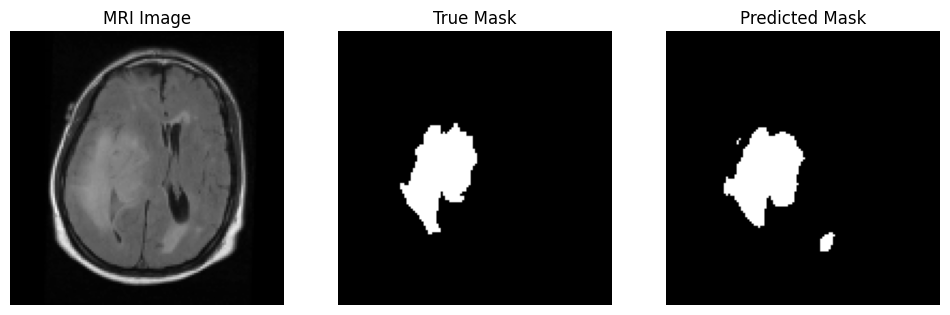

In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
    for i in range(15):
        img, mask = test_dataset[i]
        img = img.unsqueeze(0).to(device)

        pred = model(img).cpu().numpy()[0,0]
        true = mask.numpy()[0]

        plt.figure(figsize=(12,4))

        plt.subplot(1,3,1)
        plt.title("MRI Image")
        plt.imshow(img.cpu().numpy()[0,0], cmap='gray')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title("True Mask")
        plt.imshow(true, cmap='gray')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title("Predicted Mask")
        plt.imshow(pred > 0.5, cmap='gray')
        plt.axis('off')

        plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import torch

# Dice Score
def dice_score(pred, target, smooth=1e-7):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2 * intersection + smooth) / (union + smooth)

# IoU Score
def iou_score(pred, target, smooth=1e-7):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    total = pred.sum() + target.sum()
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

# Evaluate on Test Set
model.eval()
dice_scores = []
iou_scores = []

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)

        dice_scores.append(dice_score(preds, masks).item())
        iou_scores.append(iou_score(preds, masks).item())

print("📌 Final Dice Score:", sum(dice_scores) / len(dice_scores))
print("📌 Final IoU Score :", sum(iou_scores) / len(iou_scores))


📌 Final Dice Score: 0.8110334786564805
📌 Final IoU Score : 0.6937816375216772


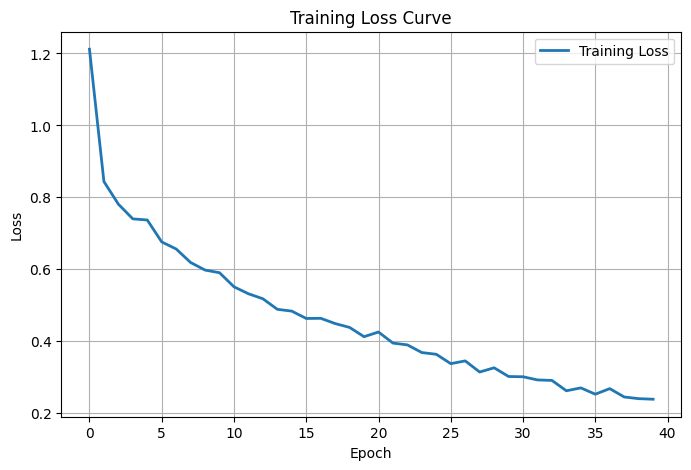

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def predict_single_image(image_path):
    # load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img_norm = img / 255.0

    # add dimensions (1,1,128,128)
    img_tensor = torch.tensor(img_norm, dtype=torch.float32)
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device)

    # prediction
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor).cpu().numpy()[0,0]

    # display
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Input MRI")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title("Predicted Mask")
    plt.imshow(pred > 0.5, cmap='gray')
    plt.axis('off')
    plt.show()

# Example:
# predict_single_image("/content/sample_image.png")
